<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
!pip install pandas seaborn scikit-learn requests

Defaulting to user installation because normal site-packages is not writeable


We will import the following libraries for the lab


In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

In [3]:
import sklearn
sklearn.show_versions()


System:
    python: 3.11.9 (main, Apr 10 2024, 04:38:20) [GCC 12.2.0]
executable: /usr/local/bin/python
   machine: Linux-5.15.146.1-microsoft-standard-WSL2-x86_64-with-glibc2.36

Python dependencies:
      sklearn: 1.5.0
          pip: 24.0
   setuptools: 65.5.1
        numpy: 1.26.4
        scipy: 1.13.1
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.9.0
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 12
         prefix: libopenblas
       filepath: /home/pyuser/.local/lib/python3.11/site-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
        version: 0.3.23.dev
threading_layer: pthreads
   architecture: Haswell

       user_api: blas
   internal_api: openblas
    num_threads: 12
         prefix: libopenblas
       filepath: /home/pyuser/.local/lib/python3.11/site-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so
        version: 0.3.27
threading_layer:

This function is to plot the confusion matrix.


In [4]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [5]:
import requests
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = requests.get(URL1)
text1 = io.StringIO(resp1.text)
data = pd.read_csv(text1)

In [6]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [7]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = requests.get(URL2)
text2 = io.StringIO(resp2.text)
X = pd.read_csv(text2)

In [8]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [9]:
X.columns

Index(['FlightNumber', 'PayloadMass', 'Flights', 'Block', 'ReusedCount',
       'Orbit_ES-L1', 'Orbit_GEO', 'Orbit_GTO', 'Orbit_HEO', 'Orbit_ISS',
       'Orbit_LEO', 'Orbit_MEO', 'Orbit_PO', 'Orbit_SO', 'Orbit_SSO',
       'Orbit_VLEO', 'LaunchSite_CCAFS SLC 40', 'LaunchSite_KSC LC 39A',
       'LaunchSite_VAFB SLC 4E', 'LandingPad_5e9e3032383ecb267a34e7c7',
       'LandingPad_5e9e3032383ecb554034e7c9',
       'LandingPad_5e9e3032383ecb6bb234e7ca',
       'LandingPad_5e9e3032383ecb761634e7cb',
       'LandingPad_5e9e3033383ecbb9e534e7cc', 'Serial_B0003', 'Serial_B0005',
       'Serial_B0007', 'Serial_B1003', 'Serial_B1004', 'Serial_B1005',
       'Serial_B1006', 'Serial_B1007', 'Serial_B1008', 'Serial_B1010',
       'Serial_B1011', 'Serial_B1012', 'Serial_B1013', 'Serial_B1015',
       'Serial_B1016', 'Serial_B1017', 'Serial_B1018', 'Serial_B1019',
       'Serial_B1020', 'Serial_B1021', 'Serial_B1022', 'Serial_B1023',
       'Serial_B1025', 'Serial_B1026', 'Serial_B1028', 'Serial_B102

## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [10]:
Y = data["Class"].to_numpy()
Y 

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [11]:
# students get this 
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [13]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [14]:
parameters = {"C": [0.01,0.1,1], 'penalty': ['l2'], 'solver': ['lbfgs'] } # l1 lasso l2 ridge
lr = LogisticRegression()
logreg_cv = GridSearchCV(lr, param_grid=parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [15]:
print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
print("accuracy :", logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [16]:
logreg_test_score = logreg_cv.score(X_test, Y_test)
logreg_test_score

0.8333333333333334

Lets look at the confusion matrix:


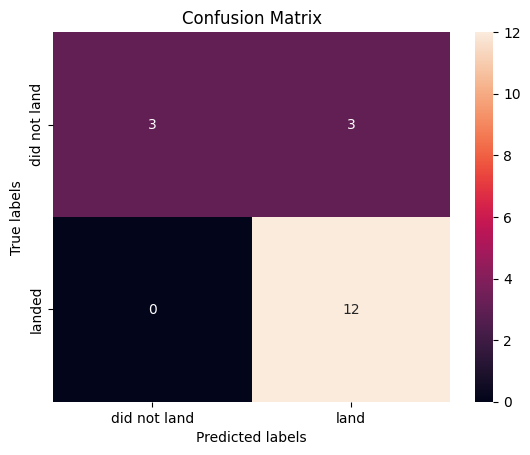

In [32]:
logreg_yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test, logreg_yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [18]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
svm_cv = GridSearchCV(svm, param_grid=parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [19]:
print("tuned hpyerparameters :(best parameters) ", svm_cv.best_params_)
print("accuracy :", svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [20]:
svm_test_score = svm_cv.score(X_test, Y_test)
svm_test_score

0.8333333333333334

We can plot the confusion matrix


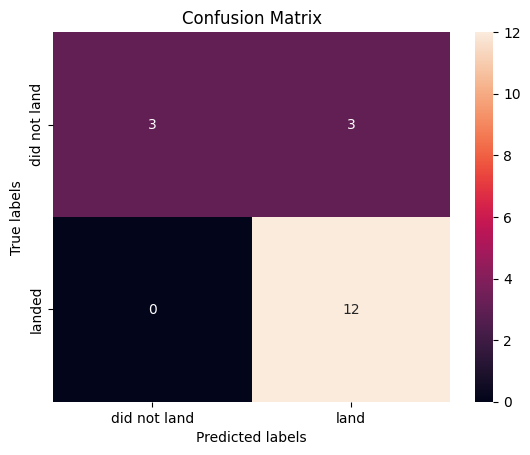

In [33]:
svm_yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, svm_yhat)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [42]:
parameters = {
    'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': [None, 'log2', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]
}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, param_grid=parameters, cv=10)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': [None, 'log2', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [43]:
print("tuned hpyerparameters :(best parameters) ", tree_cv.best_params_)
print("accuracy :", tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.8857142857142856


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [44]:
tree_test_score = tree_cv.score(X_test, Y_test)
tree_test_score

0.8333333333333334

We can plot the confusion matrix


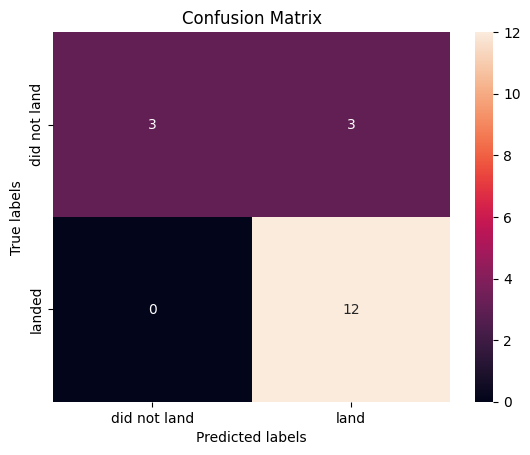

In [34]:
tree_yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, tree_yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [26]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, param_grid=parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [27]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [28]:
knn_test_score = knn_cv.score(X_test, Y_test)
knn_test_score

0.8333333333333334

We can plot the confusion matrix


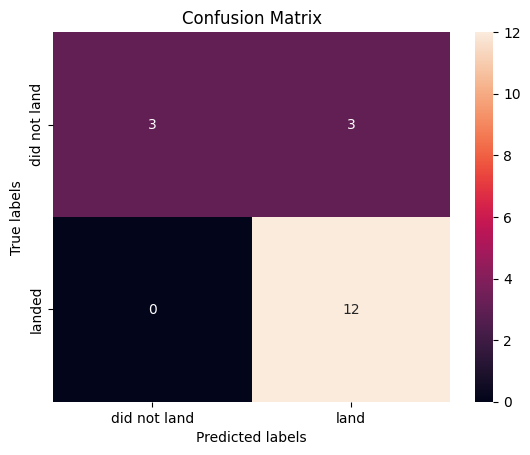

In [35]:
knn_yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, knn_yhat)

## TASK  12


Find the method performs best:


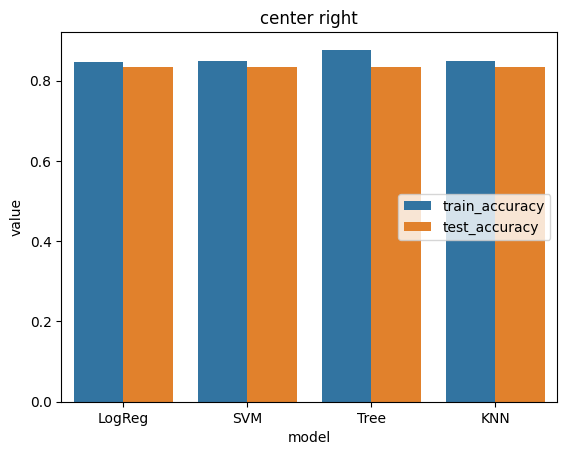

In [30]:
d = {
    'model': ['LogReg', 'SVM', 'Tree', 'KNN'],
    'train_accuracy': [logreg_cv.best_score_, svm_cv.best_score_, tree_cv.best_score_, knn_cv.best_score_],
    'test_accuracy': [logreg_test_score, svm_test_score, tree_test_score, knn_test_score],
}
results_df = pd.DataFrame(data=d).melt(id_vars='model')

sns.barplot(data=results_df, x='model', y='value', hue='variable')
plt.title('center right')
plt.legend(loc='center right')
plt.show()

In [45]:
from sklearn.metrics import jaccard_score, f1_score

# Examining the scores from Test sets
jaccard_scores = [
    jaccard_score(Y_test, logreg_yhat, average='binary'),
    jaccard_score(Y_test, svm_yhat, average='binary'),
    jaccard_score(Y_test, tree_yhat, average='binary'),
    jaccard_score(Y_test, knn_yhat, average='binary'),
]

f1_scores = [
    f1_score(Y_test, logreg_yhat, average='binary'),
    f1_score(Y_test, svm_yhat, average='binary'),
    f1_score(Y_test, tree_yhat, average='binary'),
    f1_score(Y_test, knn_yhat, average='binary'),
]

accuracy = [
    logreg_test_score,
    svm_test_score,
    tree_test_score,
    knn_test_score
]

scores = pd.DataFrame(
    [jaccard_scores, f1_scores, accuracy],
    index=['Jaccard_Score', 'F1_Score', 'Accuracy'],
    columns=['LogReg', 'SVM', 'Tree', 'KNN']
)
scores

,LogReg,SVM,Tree,KNN
Jaccard_Score,0.800000,0.800000,0.800000,0.800000
F1_Score,0.888889,0.888889,0.888889,0.888889
Accuracy,0.833333,0.833333,0.833333,0.833333


In [46]:
# Examining the scores from Test sets
jaccard_scores = [
    jaccard_score(Y, logreg_cv.predict(X), average='binary'),
    jaccard_score(Y, svm_cv.predict(X), average='binary'),
    jaccard_score(Y, tree_cv.predict(X), average='binary'),
    jaccard_score(Y, knn_cv.predict(X), average='binary'),
]

f1_scores = [
    f1_score(Y, logreg_cv.predict(X), average='binary'),
    f1_score(Y, svm_cv.predict(X), average='binary'),
    f1_score(Y, tree_cv.predict(X), average='binary'),
    f1_score(Y, knn_cv.predict(X), average='binary'),
]

accuracy = [
    logreg_cv.score(X, Y),
    svm_cv.score(X, Y),
    tree_cv.score(X, Y),
    knn_cv.score(X, Y)
]

scores = pd.DataFrame(
    [jaccard_scores, f1_scores, accuracy],
    index=['Jaccard_Score', 'F1_Score', 'Accuracy'],
    columns=['LogReg', 'SVM', 'Tree', 'KNN']
)
scores

,LogReg,SVM,Tree,KNN
Jaccard_Score,0.833333,0.845070,0.920635,0.819444
F1_Score,0.909091,0.916031,0.958678,0.900763
Accuracy,0.866667,0.877778,0.944444,0.855556


The method that performs the best is Decision Tree Classifier with the highest accuracy of 0.9444444444444444 . and no false negatives and the lowest value for false positives 1

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
